# Researching & Developing a Market Neutral Strategy - Case Study - USD-EUR Exchange Rate

The following notebook aims to demonstrate best practices when developing a market-neutral signal based on Quantopian's data feeds. Following the steps detailed in [this post](https://www.quantopian.com/posts/using-alternative-data-researching-and-implementing-a-market-neutral-strategy) and demonstrated in this notebook will ensure a well-founded alternative data signal that stands a better chance of holding up during out-of-sample validation and live trading.

### Intro - Why use Alternative Data?
Fundamental asset data such as price, volume, or company financials has many benefits including its accessibility and simplicity. However, these advantages are a double-edged sword as any "alpha" left in these datasets can be especially difficult to extract exactly because of the amount of people using the data. 

Because alternative data streams are not as widely available or as easy to use as fundamental ones, finding novel information that has yet to be "priced in" by the market is easier. Further benefits include the tendency for alternative data signals to be uncorrelated to ones based on traditional data.

Some of the major drawbacks of alternative data include its lack of structure, cost, exclusivity, and high dimensionality. Luckily, Quantopian takes down some of these barriers through its [wide variety of alternative data feeds](https://www.quantopian.com/data/), many of which are free to use and all of which have been cleaned and standardized to work both in pipeline and as interactive datasets in the research environment.

### Abstract

Through some preliminary research (reading papers, exploring data) we arrive at a new hypothesis we would like to test:

** Hypothesis: ** *Equity home bias results in international-domiciled equities being undervalued. US equities with strong inverse correlations to the USD-EUR exchange rate show similarities to these international assets, and because they are US equities and subject to US market biases equity home bias will cause them to be undervalued.*

To test it we:

1) Examine the data and look for the presence of US equity home bias within the research period 2004-2011.

2) Use pipeline to identify US equities strong positive or inverse correlations to the USD-EUR exchange rate. We can then sort the equities into groups based off of their correlations and use those classifications to conduct further tests to try to back up the hypothesis.

3) Use Alphalens to examine the strength of our signal within the in-sample period.


We finish by implementing an algorithm based on the [long short equity template](https://www.quantopian.com/lectures/example-long-short-equity-algorithm), running the backtest over the research period and walking forward one year out-of-sample, and analyzing the results using Pyfolio.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import blaze as bz
import math
import numpy as np
import seaborn
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.tsa as tsa

from statsmodels import regression
from odo import odo

# Researching Alternative Data: USD-EUR Exchange Rate
This exchange rate data used in this notebook, as well as the Morningstar fundamental data, are all available as free datafeeds. 

** Preliminary Hypothesis: ** *The assets in the Q1500US and Q500US universes are all US-based equities and will therefore be affected by the strength of the US dollar. The USD-EUR exchange rate is a good indicator of the strength of the USD and therefore it is worth investigating relationships between the returns of US companies and their correlation with the exchange rate.*

To protect against overfitting, we will conduct our research strictly within the interval 2004-2010, leaving the data for 2011 and after for out-of-sample validation.

In [2]:
# Importing exchange rate data set
# When importing for blaze/non-pipeline research use quantopian.interactive._
# When importing for pipeline use quantopian.pipeline._
from quantopian.interactive.data.quandl import currfx_usdeur

In [3]:
# Exchange rate data is small enough to compute directly into a Pandas DataFrame
data = bz.compute(currfx_usdeur)

# We'll set 'asof_date' as our index, and add a timedelta of 1 day to prevent look ahead bias
# This is because we will not have a good idea about FX data for a specific day until the day after
data = data.set_index(data['asof_date']+pd.Timedelta('1 days')).sort_index().drop('timestamp', 1)
del data['asof_date']

# Renaming columns
data.columns = ['rate', 'high_est', 'low_est']

# Dropping '0' values in the high_est and low_est columns as well as an outlier high_est value of 14
data['high_est'][(data['high_est'] == 0) | (data['high_est'] > 10)] = None
data['low_est'][data['low_est'] == 0] = None

----------- US/Euro Exchange Rate Data -----------
Start:       1999-09-07      End:          2017-08-05
Min Value:   0.627189        Max Value:    1.2064
Avg Value:   0.83432624441   Median Value: 0.791828

Fields: rate high_est low_est
Frequency: daily



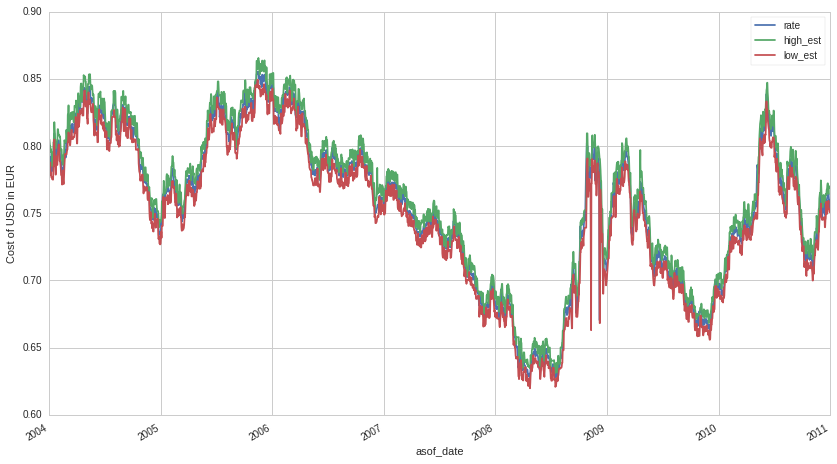

In [4]:
# Getting an understanding of the size and structure of the data by finding 
print "----------- US/Euro Exchange Rate Data -----------"
def summary(data):
    print "%-12s %-15s %-13s %s" % ('Start:', data.index[0].date(), 
                                    'End:', data.index[-1].date())
    print "%-12s %-15s %-13s %s" % ('Min Value:', data.min(), 
                                    'Max Value:', data.max())
    print "%-12s %-15s %-13s %s" % ('Avg Value:', data.mean(), 
                                    'Median Value:', data.median())

summary(data['rate'])

print "\nFields:", data.columns[0], data.columns[1], data.columns[2]
print "Frequency: daily\n"

# Conduct research within this time frame, leaving ample room for out-of-sample-testing
start = '2004-01-01'
end = '2011-01-01'

# Plot rate, high_est, low_est for our window
# Used ffill to fill empty high_est and low_est days with most recent value
data[start:end].ffill().plot();
plt.ylabel('Cost of USD in EUR');

## Macro vs. Asset-Level Data

One classifier for datasets is whether, for a given point in time, they provide individual values for every asset (such as sentiment, earnings surprises, dividends) or a single macro value (like FX, inflation, or gold prices). 

An important concept when dealing with macro data like FX is how to apply it to get a unique value for every asset in your universe. The logic you use to decompose a single macro indicator into many asset-level ranking values requires some thought. Some approaches include:

* Correlation
* Regression beta coefficient
* Spearman rank correlation
* Cointegration

After some experimentation with the data along the above guidelines, it became apparent that assets with a low correlation of returns to the USD-EUR exchange rate consistently outperformed those with a high one, despite the exchange rate remaining mostly flat over the time period. 

While it may seem tempting to end the process here and put this signal into an algorithm, such a decision would leave you susceptible to overfitting. Without understanding *why* the signal exists means it might as well have come from random chance, and a signal found on random chance alone will probably not hold up during live trading or out-of-sample validation. To learn more about overfitting, refer to the Quantopian [Dangers of Overfitting](https://www.quantopian.com/lectures/the-dangers-of-overfitting) lecture. Researching and understanding an underlying economic hypothesis, a "story" as to why the signal works, will help reduce this risk. 

Having a story behind an alpha signal has further benefits beyond reducing overfitting. Should a signal begin to perform poorly, having an economic hypothesis to dissassemble lets you isolate what changed and how to fix it. 

## Equity Home Bias Puzzle
One possible 'story', or explanation, as to why negatively correlated stocks outperform positively correlated ones is the [Equity Home Bias Puzzle](https://en.wikipedia.org/wiki/Equity_home_bias_puzzle). Equity home bias is the tendency for individuals and institutions to hold small amounts of foreign equity investments, despite empirical evidence suggesting "substantial benefits from international diversification." The few possible explanations there are have to do with information immobility and fear of exposure to foreign exchange risk.

It is possible (and we will try to see if this is true later) that US equities with strong inverse correlations to the USD-EUR exchange can serve as proxies for these international assets because of their inverse relation to the strength of the dollar. If this is the case, because they are US equities and subject to US market biases it is possible that they will be undervalued.

** Refined Hypothesis: ** *Equity home bias results in international-domiciled equities being undervalued. US equities with strong inverse correlations to the USD-EUR exchange rate might show similarities to these international assets, and because they are US equities and subject to US market biases equity home bias could cause them to be undervalued.*

### Detecting Equity Home Bias

Because our story is based on the presence of this bias it is important to make sure it exists within our test period 2004-2010. We will use some of the methods in [this paper](https://www.aeaweb.org/conference/2015/retrieve.php?pdfid=437) to estimate home bias.$^1$ 

Data on cross-border US portfolio holdings is from the [U.S. Department of the Treasury](https://www.treasury.gov/resource-center/data-chart-center/tic/Pages/fpis.aspx)(part B) and US/EU market cap data is from the [World Bank](http://data.worldbank.org/indicator/CM.MKT.LCAP.CD?end=2016&start=1975&view=chart). 

In [6]:
# List of eurozone countries
euro_countries = ['Austria', 'Belgium','Finland','France','Germany',
                 'Greece','Ireland','Italy','Netherlands','Portugal',
                 'Slovakia','Slovenia','Spain','Cyprus','Estonia','Latvia',
                 'Luthuania','Luxembourg','Malta']

# Pull cross-border holdings from U.S. Department of the Treasury
foreign_holdings = local_csv('shchistdat.csv')

# Selecting only investments in eurozone nations and fixing date order
euro_investments = foreign_holdings.loc[foreign_holdings['Unnamed: 1'].isin(euro_countries)][range(2,49,4)]
euro_investments.columns = pd.date_range(end='2015-01-01',periods=12,freq='AS')[::-1]

# Removing thousands separator commas and converting strings of numbers to ints
for column in euro_investments.columns:
    euro_investments[column] = euro_investments[column].str.replace(',','').astype(int)

# Multiply by 1 million because CSV data unit was millions    
euro_investments = euro_investments.sum()*1000000

# Pull country market caps from World Bank
mkt_caps = local_csv('API_CM.MKT.LCAP.CD_DS2_en_csv_v2.csv')

# Select only eurozone and US market caps using country code
mkt_caps = mkt_caps[mkt_caps['Country Code'].isin(['EMU','USA'])]

# Isolating market cap data by country and to within our research range 
USA  = mkt_caps.iloc[1][start[:4]:end[:4]]
EMU = mkt_caps.iloc[0][start[:4]:end[:4]]

# Finding Euro-USA market cap ratio, Euro-Domestic US investments ratio
# and the difference between the two
mkt_ratio = EMU/USA
holdings_ratio = (euro_investments/(USA-euro_investments))[start[:4]:end[:4]]
holdings_ratio.index = mkt_ratio.index
diff = mkt_ratio - holdings_ratio

print 'Ratios of Europe-Based Equities to US-Based Equities:\n'

print 'US Investor Average:', holdings_ratio.mean()
print 'CAPM Optimal Ratio:', mkt_ratio.mean()

print '\nDifference:', diff.mean()

Ratios of Europe-Based Equities to US-Based Equities:

US Investor Average: 0.0787304762136
CAPM Optimal Ratio: 0.408553054291

Difference: 0.329822578077


[CAPM](https://en.wikipedia.org/wiki/Capital_asset_pricing_model) dictates that the optimal portfolio is one with weights based on the market capitalization of equities within the universe. As such, an optimal international portfolio should have a ratio of US to EU equities equal to the ratio of the size of the total US and EU equity markets.

Across 2004-2010, the European equity market cap was 40.9% of the size of the US equity market cap; according to CAPM, any optimal investment portfolio should have similar proportions of US to European equities. 

However, the US Treasury data shows that during our time period US investor portfolios had a Euro-US equity ratio around 7.9%, around one-fifth of the optimal amount. This discrepancy could be a result of home bias, and this test suggests its presence during the research period.

# Designing a Pipeline

Let's build a [pipeline](https://www.quantopian.com/tutorials/pipeline) to pull in rolling USD-EUR rate correlations for every asset in the Q500US universe. Using pipeline and a custom factor makes finding correlations for hundreds of equities across 7 years of data easier. When we are finished with this stage, the pipeline output can go straight into Alphalens and the pipeline itself can be copied and pasted into the IDE to be used in an algorithm.

In [7]:
# Pipeline API imports
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

# Importing built in factors, universe, and data
from quantopian.pipeline.factors import SimpleMovingAverage, CustomFactor, Returns
from quantopian.pipeline.filters.morningstar import Q1500US, Q500US
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.classifiers.morningstar import Sector

# Import FX rate and other data
from quantopian.pipeline.data.quandl import currfx_usdeur
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.data.psychsignal import stocktwits

In [8]:
# Defining our USD-EUR exchange rate correlation custom factor
class FXCorr(CustomFactor):
    """ Custom factor to find correlation of asset returns and FX rate """
    
    inputs = [USEquityPricing.close, currfx_usdeur.rate]
    window_length = 150
    def compute(self, today, asset_ids, out, close, exch_rate):
        # Converting data to returns DataFrame to make correlation calculation faster
        exch_df = pd.DataFrame(np.repeat(exch_rate, len(close[0]), axis = 1)).pct_change(1)
        close_df = pd.DataFrame(close).pct_change(1)
        
        out[:] = exch_df.corrwith(close_df)

In [9]:
# Assigning the Q500US as our universe
universe = Q500US()

# Buildling our pipeline
pipe = Pipeline(
    columns={
        'fx_corr' : FXCorr(mask=universe),
    },
    screen=(universe)
)

# Stores pipeline in result
result = run_pipeline(pipe, start, end)

# Finds assets and pricing data
assets = result.index.levels[1].unique()
pricing = get_pricing(assets, start_date = start, end_date = end, fields = 'price')

The distribution of mean FX correlations across the Q500US:

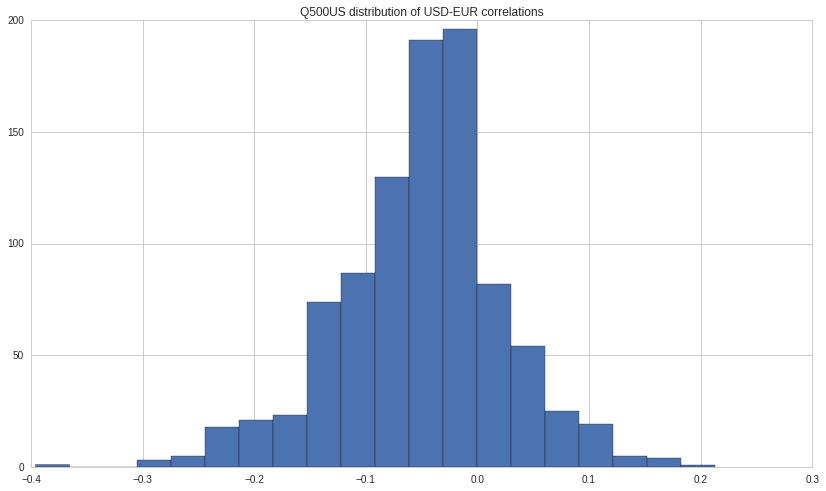

In [10]:
result.unstack()['fx_corr'].mean().hist(bins=20);
plt.title('Q500US distribution of USD-EUR correlations');

## Further Testing our Hypothesis using Pipeline

The difference between CAPM optimal diversification and observed US investor diversification suggest that equity home bias exists within our time period, but we have not explored whether or not US equities with strong inverse correlations to the dollar share similarities with international markets. If that is the case, there is the possiblity that they will be subject to the same home bias as international assets. 

To see if the assuption that low FX correlation US equities can represent international assets holds, let's compare the returns of the following:

* An ETF that tracks the FTSE Developed Europe All-Cap Index (`VGK`)
* A bucket of 25 stocks with strong negative correlations to FX rate
* A bucket of 25 stocks with strong positive correlations to FX rate

In [11]:
low_bucket = result.unstack()['fx_corr'].mean().sort_values(ascending=True)[:25].index
high_bucket = result.unstack()['fx_corr'].mean().sort_values(ascending=False)[:25].index

returns = pd.DataFrame()

# Creating equally weighted portfolios of both buckets by first finding pricing using get_pricing
# then using the pct_change() attribute to find returns, and finally averaging across all assets in the bucket
returns['low_bucket'] = get_pricing(low_bucket, start_date=start, end_date=end, 
                                    fields = 'price').pct_change()[1:].dropna(axis=1).mean(axis=1,skipna=True)
returns['high_bucket'] = get_pricing(high_bucket, start_date=start, end_date=end, 
                                     fields = 'price').pct_change()[1:].dropna(axis=1).mean(axis=1,skipna=True)
returns['vgk'] = get_pricing('vgk', start_date=start, end_date=end, fields = 'price').pct_change()[1:]

print 'Correlations of returns:'
print returns.corr()

Correlations of returns:
             low_bucket  high_bucket       vgk
low_bucket     1.000000     0.788119  0.838185
high_bucket    0.788119     1.000000  0.735325
vgk            0.838185     0.735325  1.000000


Within this time period, it seems like the `low_bucket` portfolio is more closely correlated with the Euro index than the `high_bucket` portfolio, indicating assets with a strong inverse correlation to the exchange rate share similarities to international assets. **This is far from any sort of proof of our theory**, and we did not account for events like delistings or M&As which could have affected these results. We also still need more evidence to show that assets with low correlation to the exchange rate can be subject to foreign equity bias, and that assets subject to foreign equity bias are undervalued in the first place. Despite this gap, we will proceed to the next step, keeping in mind that our hypothesis could use some more reinforcement.

# Analyzing our Factor with Alphalens

[Alphalens](https://www.quantopian.com/posts/alphalens-a-new-tool-for-analyzing-alpha-factors) will help us evaluate the strength of our `fx_corr` factor within the sample. We will use 1, 10, and 30-day return periods as our factor is based on a long-term relationship between assets and the exchange rate and should therefore be evaluated on a long-term basis.

In [12]:
import alphalens as al

# Formats the factor data, pricing data, and group mappings into a DataFrame 
# necessary for most Alphalens tearsheets.
# We invert the sign of our factor as we want the lowest correlations to have highest weights
# and the highest correlations to have the lowest weights.
factor_data = al.utils.get_clean_factor_and_forward_returns(factor=-result['fx_corr'],
                                                            prices=pricing,
                                                            quantiles=5,
                                                            periods=(1,10,30))

In [13]:
al.performance.factor_alpha_beta(factor_data)

,1,10,30
Ann. alpha,0.043056,0.049052,0.050816
beta,0.093142,0.085254,0.083962


/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:767: FutureWarning: pd.rolling_apply is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,min_periods=1,window=30).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))


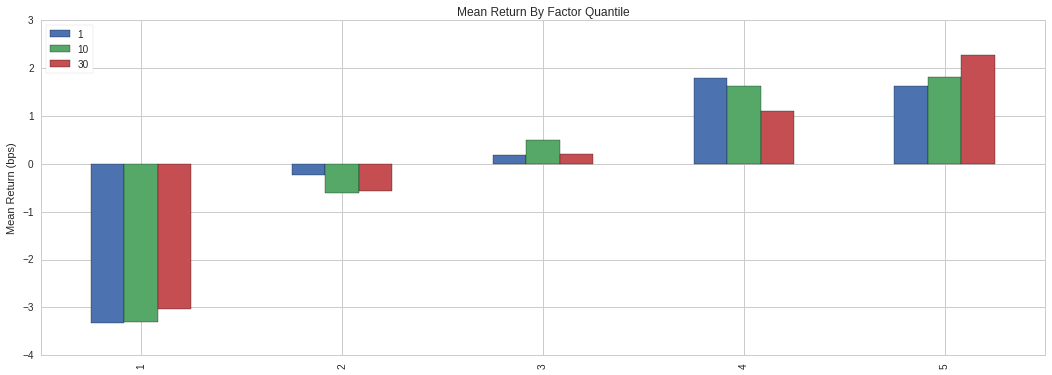

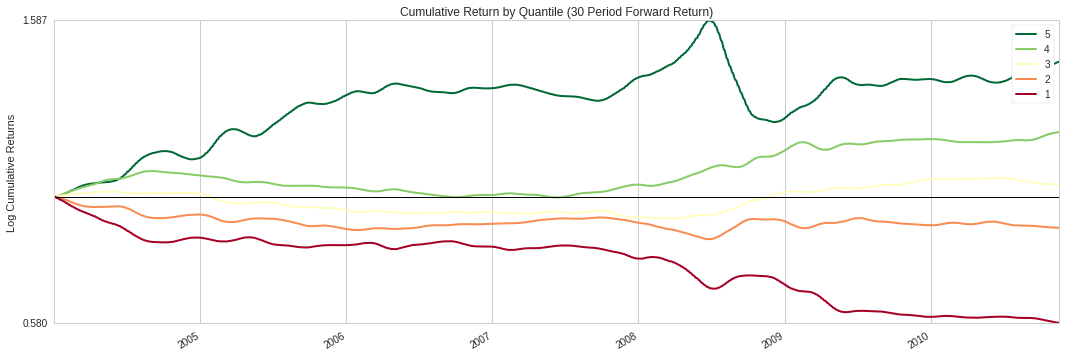

In [14]:
# Use Alphalens to get mean returns by quantile over 1, 10, and 30 day windows
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data, by_group=False)
mean_return_by_q_daily, std_err_by_q_daily = al.performance.mean_return_by_quantile(factor_data, by_date=True)

al.plotting.plot_quantile_returns_bar(mean_return_by_q.apply(al.utils.rate_of_return, axis=0));
al.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q_daily, period=30);

In [15]:
mean_return_by_q

,1,10,30
factor_quantile,,,
1,-0.000333,-0.003301,-0.009091
2,-0.000023,-0.000614,-0.001685
3,0.000018,0.000496,0.000637
4,0.000178,0.001620,0.003299
5,0.000162,0.001811,0.006867


For a full Alphalens tearsheet, run the following cell:

In [ ]:
al.tears.create_full_tear_sheet(factor_data)

# Implement and Backtest the Strategy in the IDE
We can use the [long-short equity algorithm template](https://www.quantopian.com/lectures/example-long-short-equity-algorithm) to make this step easier. 

The long-short equity template works by ranking equities within a universe along some ranking factor. It then longs the top of the ranking and shorts the bottom, rebalancing every month. It also uses the Optimize API, with sector neutrality, beta neutrality, and position concentration constraints, to handle ordering logic and assign appropriate weights.

To implement a long-short equity strategy with our `fx_corr` factor, we find the custom factor in the algorithm and copy and paste our `fx_corr` in its place. We can also make any other changes we deem suitable. For this algorithm, lets:

* Comment out the other factors ('value' and 'quality') as we want to isolate our FX factor instead of aggregating it with two others to create a combined rank
* Comment out lines  these lines turn off slippage and commissions but we want their effects included
* Switch from the Q1500US to the Q500US as it was the Q500US we use throughout our research
* Reduce both `NUM_LONG_POSITIONS` and `NUM_SHORT_POSITIONS` to 100 from 300. We are switching to a universe one third the size so we should proportionally scale this size of our our long and short positions

# Analyze Our Backtest Using Pyfolio
Our in-sample research up until this point was almost entirely contained within the time period 2004-2010. We will run the backtest from 2004-2011, adding in a single year of out-of-sample testing. As a result, the most important part of the below Pyfolio tearsheets will be performance within 2011.

$$
 \
   \overbrace{
    \underbrace{\textit{2004, 2005, ... 2010}}_\text{In-Sample}\:\:+
    \underbrace{\textit{2011}}_\text{Out-of-Sample}
   }^\text{Backtest}
 \
$$

In [7]:
import pyfolio as pf
from pyfolio import tears
from pyfolio import timeseries
import itertools
import functools

# Get backtest object
bt = get_backtest('5984b88018063e557a3a9cd4')

100% Time: 0:00:03|###########################################################|


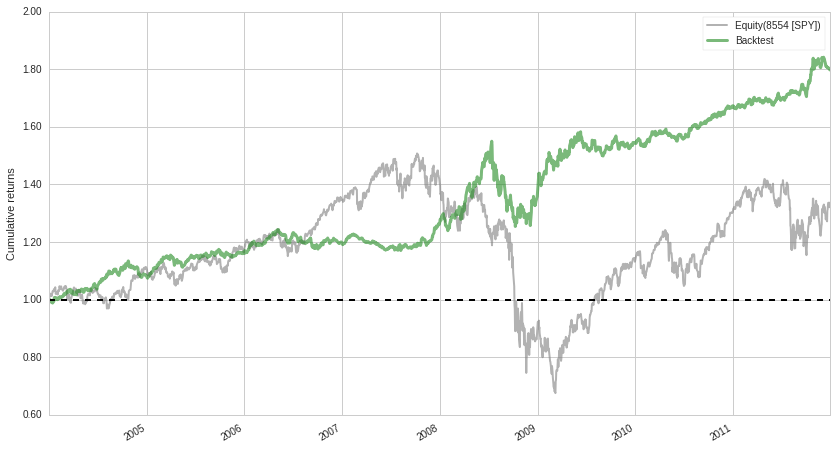

In [8]:
algo_performance = bt.daily_performance
benchmark = get_pricing('SPY', start_date=start, end_date='2012-01-01', fields = 'price').pct_change()[1:]
pf.plotting.plot_rolling_returns(algo_performance['returns'], factor_returns=benchmark);

Let's try to find the main drivers of the algorithm's performance. First we can use the Fama-French factor tearsheet from Pyfolio with a 60 day rolling window to measure exposures to the three fundamental factors (market cap, book to price, and momentum). 

CSVs with the returns for these factors can be found [here](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html).$^2$

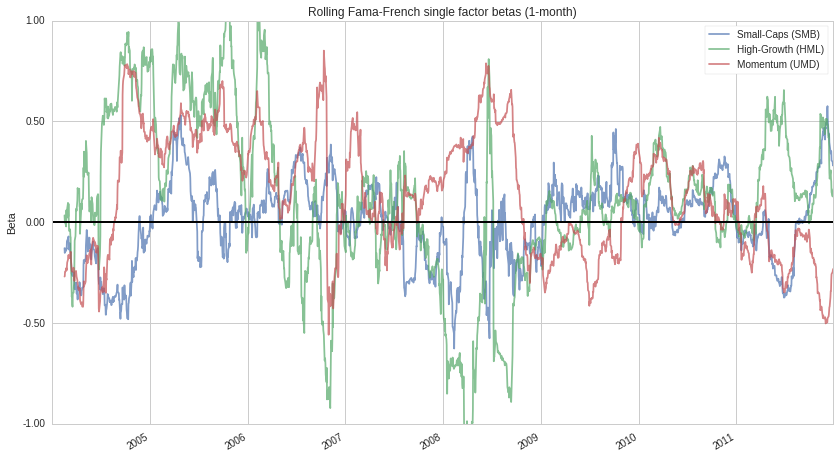

In [18]:
pf.plotting.plot_rolling_fama_french(algo_performance['returns'], rolling_window=30);

Let's try to decompose returns into segments explained by the above factors. This will help us see exactly how much of the algo's returns over the time period are atrributable to exposure to these factors.


### Returns Decomposition into Fama-French Factors

Below analysis was inspired by Exhibit 3 in [a report by AQR on Measuring Factor Exposure](https://www.aqr.com/-/media/files/papers/measuring-factor-exposures-uses-and-abuses.pdf).$^3$ It yields a breakdown of how much exposure to each risk factor contributes to the algorithm's returns in excess of the risk-free rate. 

In [31]:
a = range(10)
a[1::2]

[1, 3, 5, 7, 9]

In [55]:
def find_vifs(data):
    data = pd.DataFrame(data)
    cols = data.columns
    VIFs = pd.Series(index=cols)
    for x, column in enumerate(cols):
        # Calculates VIF using steps described here: 
        # https://en.wikipedia.org/wiki/Variance_inflation_factor#Calculation_and_Analysis
        VIFs[column] = 1/(1-regression.linear_model.OLS(data.iloc[:,x], 
        sm.add_constant(np.column_stack((
            [data.iloc[:,(x+i+1)%len(cols)] for i in range(len(cols)-1)] 
        )))).fit().rsquared)      
    return VIFs

def decompose_returns_custom(algo_returns, risk_factors, plot):
    
    # Get excess returns for algo and risk-free rate from Dartmouth using Pyfolio
    risk_free = pf.utils.load_portfolio_risk_factors().loc[algo_returns.index]['RF']
    algo_rets_over_rf = algo_returns - risk_free
    algo_returns_ann = algo_rets_over_rf.mean()*252
    
    # Write index for betas dataframe
    betas_index = ['Alpha','Alpha t-stat']
    for factor in risk_factors.columns.values:
        betas_index = betas_index+[factor]+['{} t-stat'.format(factor)]

    # Create dataframes to store betas and return contributions
    betas = pd.DataFrame(columns = [risk_factors.columns.values],
                                        index = betas_index)
    returns_decomposition = pd.DataFrame(index = itertools.chain(['Alpha'],risk_factors.columns.values),
                                        columns = risk_factors.columns.values)

    # Nested iteration through models and factors in each model
    for factor in risk_factors.columns.values:
        model_factors = sm.add_constant(risk_factors.loc[:,:factor]).loc[algo_rets_over_rf.index]
        model = sm.OLS(algo_rets_over_rf, model_factors).fit()
        for i in range(len(model_factors.columns)):
            beta = model.params[i]
            betas[factor].iloc[2*i] = beta
            betas[factor].iloc[2*i+1] = model.params[i]/model.HC0_se[i]
            if i>0:
                returns_decomposition[factor].iloc[i] = beta*(risk_factors.loc[algo_rets_over_rf.index].mean()*252)[i-1]

    # Annualize alphas
    betas.loc['Alpha'] = betas.loc['Alpha']*252
    returns_decomposition.loc['Alpha'] = betas.loc['Alpha']
    
    # Write column names
    rets_decomp_columns = []
    for i in range(len(risk_factors.columns.values)):
        rets_decomp_columns = rets_decomp_columns + ['Model {}: Add {}'.format(i, risk_factors.columns.values[i])]
    returns_decomposition.columns = rets_decomp_columns
    
    # Finds variance inflation factors using function defined above
    VIFs = find_vifs(risk_factors)
    
    # Plotting conditional on input
    if plot:
        
        # Make more colors to prevent default colors repeating themselves
        colors = mpl.cm.jet(np.linspace(0, 1, len(risk_factors.columns)+1))

        # Create bar graph, with horizontal lines at 0 and annualized algo returns
        ax = returns_decomposition.T.plot(kind='bar', stacked=True, rot=-30, color=colors)
        ax.plot(ax.get_xlim(),[algo_returns_ann]*len(ax.get_xlim()), linestyle = '--',
                color='black', label = 'Algo Returns');
        ax.plot(ax.get_xlim(),[0]*len(ax.get_xlim()), color='black', linewidth=4);
        ax.legend(loc='best', bbox_to_anchor=(1.0, 0.5));
        
        # Fill in green and red zones to represent positive and negative return contributions
        ylim = ax.get_ylim()
        ax.fill_between(ax.get_xlim(), 0, ylim[0], facecolor='red', alpha = 0.1)
        ax.fill_between(ax.get_xlim(), ylim[1], 0, color='green', alpha = 0.1)
        plt.ylim(ylim)
        
        plt.ylabel('Excess Returns');
        plt.title('Excess Returns Decomposition')

    return betas, returns_decomposition, risk_factors.mean()*252, algo_returns_ann, VIFs

def decompose_returns(algo_returns, plot):
    
    # Loads Fama-French risk factors from Dartmouth using Pyfolio
    risk_factors = pf.utils.load_portfolio_risk_factors().loc[algo_returns.index]
    del risk_factors['RF']
    return decompose_returns_custom(algo_returns, risk_factors, plot)

Variance Inflation Factors:
Mkt-RF    1.399355
SMB       1.091903
HML       1.659207
Mom       1.601415
dtype: float64

Betas:                   Mkt-RF        SMB        HML     Mom   
Alpha          0.0548948  0.0552833  0.0554222  0.0549158
Alpha t-stat     1.96972    1.98902    2.06561     2.0494
Mkt-RF         0.0558085  0.0575993   0.109451   0.116019
Mkt-RF t-stat    4.33964     4.1668    7.45709    7.93011
SMB                  NaN -0.0212644  -0.059929 -0.0683201
SMB t-stat           NaN  -0.762268   -2.20101   -2.38552
HML                  NaN        NaN   -0.20553  -0.176732
HML t-stat           NaN        NaN   -6.97187     -5.536
Mom                  NaN        NaN        NaN  0.0401703
Mom    t-stat        NaN        NaN        NaN    1.77766

Factor Excess Returns:
Mkt-RF    0.046373
SMB       0.022173
HML       0.008204
Mom       0.003777
dtype: float64


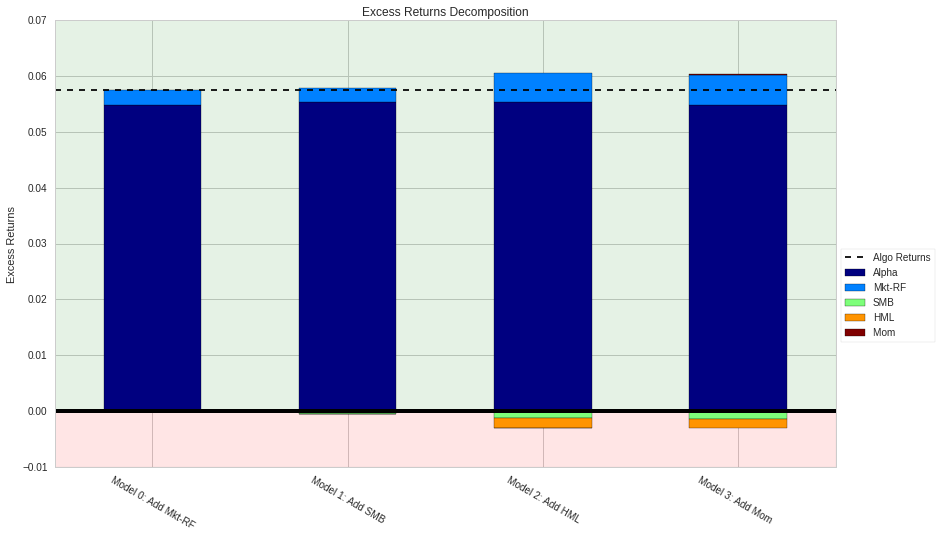

In [56]:
algo_returns = algo_performance['returns']
ff_decomposition = decompose_returns(algo_returns, plot=True)

print 'Variance Inflation Factors:\n', ff_decomposition[4]
print '\nBetas:', ff_decomposition[0]
print '\nFactor Excess Returns:\n', ff_decomposition[2]

The VIFs are all under 10 meaning multicollinearity is too small to warrant exclusion of any risk factor based on correlation with each other. Despite this, the breakdown of algo returns will be somewhat volatile so it is best to look at it across the entire sample like above as opposed to on a rolling basis. 

### Adding More Risk Factors

One of these factors, none seem to explain much of the algorithm's performance. HML had a small negative impact on returns as the algo has a significant negative exposure (t-stat: -5.4) but the factor performed well across the sample. Let's look at a couple others factors to see if they help explain some more of the returns. The ones we will investigate are:

* Volatility
* Short-term mean reversion

We can generate returns for these factors on our own:

In [21]:
class Vol_3M(CustomFactor):
        ''' Volatility Factor'''
        inputs = [Returns(window_length=2)]
        window_length = 60
        def compute(self, today, assets, out, rets):
            out[:] = np.nanstd(rets, axis=0)
            
class ST_MR(CustomFactor):
        '''Short-term Mean Reversion Factor'''
        inputs = [USEquityPricing.close]
        window_length = 5

        def compute(self, today, assets, out, price):
            out[:] = np.mean(price[-5:-1])/price[0]     

universe = Q500US()

pipe = Pipeline(
    columns={
        'VOL' : Vol_3M(mask=universe),
        'STMR' : ST_MR(mask=universe)
    },
    screen=(universe)
)

start = start
end = '2012-01-01'

alt_result = run_pipeline(pipe, start, end)

In [22]:
assets = alt_result.index.levels[1].unique()
pricing = get_pricing(assets, start_date = start, end_date = end, fields = 'price')

# Using Alphalens to get DataFrame with factor data
VOL_factor_data = al.utils.get_clean_factor_and_forward_returns(factor=alt_result['VOL'],
                                                            prices=pricing,
                                                            quantiles=5,
                                                            periods=(1, 5))
STMR_factor_data = al.utils.get_clean_factor_and_forward_returns(factor=alt_result['STMR'],
                                                            prices=pricing,
                                                            quantiles=5,
                                                            periods=(1,5))

Variance Inflation Factors:
[ 1.4053305   1.09301338  1.66741612  1.61632882  2.11854957  2.15006662]

Betas:                   Mkt-RF        SMB        HML     Mom           VOL  \
Alpha          0.0548948  0.0552833  0.0554222  0.0549158  0.0556588   
Alpha t-stat     1.96972    1.98902    2.06561     2.0494    2.08226   
Mkt-RF         0.0558085  0.0575993   0.109451   0.116019   0.117195   
Mkt-RF t-stat    4.33964     4.1668    7.45709    7.93011    8.04882   
SMB                  NaN -0.0212644  -0.059929 -0.0683201 -0.0670823   
SMB t-stat           NaN  -0.762268   -2.20101   -2.38552   -2.36404   
HML                  NaN        NaN   -0.20553  -0.176732  -0.178689   
HML t-stat           NaN        NaN   -6.97187     -5.536   -5.63988   
Mom                  NaN        NaN        NaN  0.0401703   0.039923   
Mom    t-stat        NaN        NaN        NaN    1.77766    1.77078   
VOL                  NaN        NaN        NaN        NaN -0.0269783   
VOL t-stat           NaN  

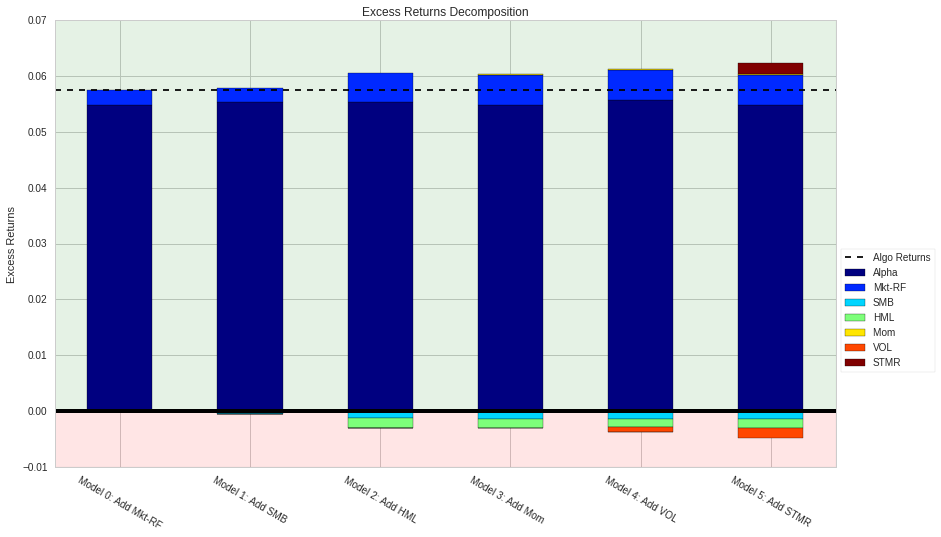

In [23]:
# Using Alphalens to get factor returns
VOL_rets = al.performance.factor_returns(VOL_factor_data)[1]
STMR_rets = al.performance.factor_returns(STMR_factor_data)[1]
alt_factors = pd.DataFrame([VOL_rets, STMR_rets], index=['VOL','STMR']).T

risk_factors = pf.utils.load_portfolio_risk_factors()
del risk_factors['RF']

new_risk_factors = pd.concat([risk_factors, alt_factors], axis=1, join_axes=[algo_returns.index]).ffill()

expanded_decomposition = decompose_returns_custom(algo_returns, new_risk_factors, plot=True)

print 'Variance Inflation Factors:\n', expanded_decomposition[4]
print '\nBetas:', expanded_decomposition[0]
print '\nFactor Excess Returns:\n', expanded_decomposition[2]

For a full Pyfolio tearsheet, run the following cell:

In [ ]:
# Create full tear sheet
bt.create_full_tear_sheet()

## Decay of US-Europe Equity Home Bias
Although our factor performed well in the above out-of-sample testing, further out-of-sample testing shows that it begins to falter after 2013. A possible reason for this is the decline of equity home bias as our factor is dependent on US investor aversion to international diversification. Let's use the home bias calculations from our research stage earlier on in the notebook, and expand them to encompass 2004-2015:

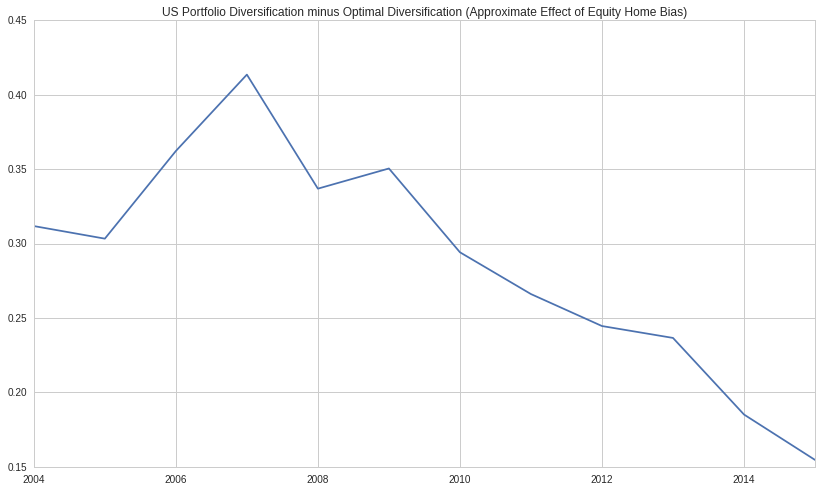

In [24]:
# Isolating market cap data by country and to within our research range 
USA  = mkt_caps.iloc[1]['2004':'2015']
EMU = mkt_caps.iloc[0]['2004':'2015']

# Finding Euro-USA market cap ratio, Euro-Domestic US investments ratio
# and the difference between the two
mkt_ratio = EMU/USA
holdings_ratio = euro_investments/(USA-euro_investments)
holdings_ratio.index = mkt_ratio.index
diff = mkt_ratio - holdings_ratio

# Plotting
diff.plot();
plt.title('US Portfolio Diversification minus Optimal Diversification (Approximate Effect of Equity Home Bias)');

With the exception of peaks right before and after the recession, equity home bias between the US and Europe has been in constant decline and with developments in globalization, trade, and communications it is expected to continue on this downwards trend. Based on this, if our economic story about home bias is correct, we coiuld maybe expect our factor to perform worse in the future as equity home bias declines.

### Possible Next Steps

* Explore biases for other foreign markets given that US-Europe home bias is declining. Although the only exchange rate offered as a data feed is the USD-EUR exchange rate, Quantopian offers currency futures data which could be used to a similar end as the FX rate was in this notebook
* Find a daily or monthly measure of US-Europe equity home bias and put it into a factor model to see if it composes much of our algos returns
* Aggregate this factor with uncorrelated alpha factors
* Attempt to fortify the hypothesis by finding better evidence for our theories that assets with strong inverse correlations to the USD-EUR exchange rate would be subject to equity home bias and that such bias can cause assets to be undervalued 
* Further out-of-sample validation

### References
Rob Reider, Jamie McCorriston, and Max Margenot

$^1$Wynter, Matthew M. "Why Has the U.S. Foreign Portfolio Share Increased?" SSRN Electronic Journal, March 2014, 6-7. Accessed July 19, 2017. doi:10.2139/ssrn.2679196.

$^2$French, Kenneth R. Factor Returns. May 31, 2017. Raw data. Dartmouth College, Hanover, NH.

$^3$Israel, Ronen, and Ross Adrienne. "Measuring Factor Exposures: Uses and Abuses." SSRN Electronic Journal, October 2015, 4-5. doi:10.2139/ssrn.2841037.


*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*